In [2]:
import json
import sys
from mrtparse import *
import networkx as nx
import matplotlib.pyplot as plt

import os
import requests
import gzip
import shutil
import openai

from neo4j import GraphDatabase


In [3]:
server_url = "https://data.ris.ripe.net"
rrc_name = "rrc00"
year = "2017"
month = "09"
date = "01"
time = "0800"

zip_file_name = "bview.{}{}{}.{}.gz".format(year,month,date,time)
filename = "bview.{}{}{}.{}".format(year,month,date,time)

remote_url = server_url + "/" + rrc_name + "/" + year + "." + month + "/" + zip_file_name
print(remote_url)

https://data.ris.ripe.net/rrc00/2017.09/bview.20170901.0800.gz


In [4]:
r = requests.get(remote_url, allow_redirects=True)

if(r.status_code==200):

    ## Removing the zip file if it exists
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)

    ## Removing content file if it exists
    if os.path.isfile(filename):
        os.remove(filename)

    ## Obtaining the zip file
    with open(zip_file_name, 'wb') as f:
        f.write(r.content)

    ## Obtaining the content file
    with gzip.open(zip_file_name, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    ## Removing the zip file after extraction
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)
else:
    print('File does not exist')

In [5]:
#edge_connections = ""

G = nx.DiGraph()
node_check = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        G.add_edge(curr_list[k+1],curr_list[k])
                        node_check.append(curr_list[k+1])
                        node_check.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    G.add_edge(curr_list[k+1],curr_list[k])
                    node_check.append(curr_list[k+1])
                    node_check.append(curr_list[k])


        i += 1

    if(i==20):
        break

#print(len(list(set(node_check))))

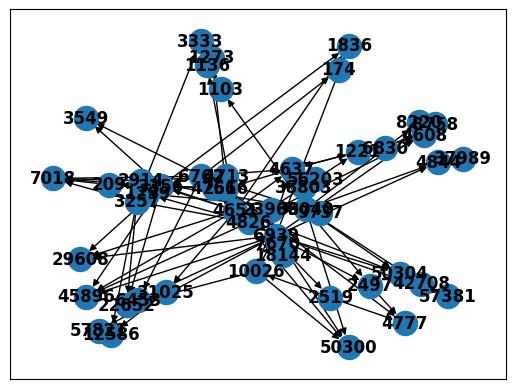

In [6]:
nx.draw_networkx(G, with_labels=True, font_weight='bold')

In [7]:
formatted_string = ""
connect_list = []
node_list = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        connect_list.append('An arc exists strating from ' + curr_list[k+1] + " into " + curr_list[k])
                        node_list.append(curr_list[k+1])
                        node_list.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    connect_list.append('An arc exists starting from ' + curr_list[k+1] + " into " + curr_list[k])
                    node_list.append(curr_list[k+1])
                    node_list.append(curr_list[k])


        i += 1

    if(i==20):
        break

connect_list = list(set(connect_list))
node_list = list(set(node_list))
formatted_string = "\n".join(connect_list)
formatted_string_nodes = ",".join(node_list)
#print(formatted_string)

## OpenAI Setup

In [8]:
import os
name = 'OPENAI_API_KEY'

key_location = "./key.txt"
key_file = open(key_location, "r")
openapi_key = key_file.readline()

#secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = openapi_key
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [9]:
# Define your API key (keep it secret!)
openai.api_key = openapi_key
API_KEY = openapi_key

## Creating examples

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import random
import pickle

In [11]:

node_list = [i for i in range(5, 36)] ## List of possible number of nodes
no_of_graphs = 150 ## Number of graphs to be generated
graph_list = []

for i in range(no_of_graphs):
    curr_node_number = random.choice(node_list)
        
    prob_edge = 0.2 # Probability of edge creation (Increase it if you want more edges)
    curr_G = nx.fast_gnp_random_graph(n=curr_node_number,
                             p=prob_edge,
                             directed=True,
                             seed=123)
    graph_list.append(curr_G)


In [12]:
curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'wb') as f:
    pickle.dump(graph_list, f)

In [13]:
curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'rb') as f:
    graph_list = pickle.load(f)

In [14]:
## Describing a graph

def describe_graph(curr_graph,curr_num):
    
    """
    Function to describe a graph with nodes and edges
    
    input:
    curr_graph : A graph object
    curr_num : Integer to describe the graph
    
    output:
    graph_desc: A string object with description about the graph
    """
    
    
    graph_desc = """"""

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes = [str(each_node) for each_node in nodes]
    edges = [('An arc exists starting from ' + str(curr_edge[0]) + " into " + str(curr_edge[1])) for curr_edge in edges]

    graph_desc = graph_desc + """
    Graph {} has nodes {}
    and the edges are described as follows

    {}
    """.format(str(curr_num),','.join(nodes),'\n  '.join(edges))

    return graph_desc

In [15]:
def describe_indegree(curr_graph):

    indegree_desc = """ 
    The indegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.in_degree(curr_node)

        indegree_desc = indegree_desc + """
        In degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [16]:
def describe_outdegree(curr_graph):

    indegree_desc = """ 
    The outdegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.out_degree(curr_node)

        indegree_desc = indegree_desc + """
        Out degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [17]:
def get_nodes_from_description(curr_graph):
    lines = curr_graph.strip().split('\n')
    first_line = lines[0]
    nodes_part = first_line.split('nodes')[1]
    # We remove any leading or trailing spaces and split the string by commas to get the individual nodes
    nodes = nodes_part.strip().split(',')
    # The number of nodes is simply the length of this list
    number_of_nodes = len(nodes)

    return number_of_nodes


In [18]:
describe_indegree(graph_list[0])

' \n    The indegree of the nodes are as follows \n    \n        In degree of node 0 is 11\n        In degree of node 1 is 11\n        In degree of node 2 is 3\n        In degree of node 3 is 5\n        In degree of node 4 is 4\n        In degree of node 5 is 4\n        In degree of node 6 is 8\n        In degree of node 7 is 5\n        In degree of node 8 is 9\n        In degree of node 9 is 8\n        In degree of node 10 is 5\n        In degree of node 11 is 4\n        In degree of node 12 is 9\n        In degree of node 13 is 4\n        In degree of node 14 is 3\n        In degree of node 15 is 5\n        In degree of node 16 is 6\n        In degree of node 17 is 4\n        In degree of node 18 is 5\n        In degree of node 19 is 6\n        In degree of node 20 is 6\n        In degree of node 21 is 6\n        In degree of node 22 is 11\n        In degree of node 23 is 4\n        In degree of node 24 is 3\n        In degree of node 25 is 4\n        In degree of node 26 is 3\n     

In [28]:

## To generate prompts for indegree

graph_node_prompt = []
graph_node_ans = []
graph_indegree_ans = []

i = 0

for each_graph in graph_list:
    graph_node_prompt.append(describe_graph(each_graph,i))
    graph_node_ans.append(get_nodes_from_description(describe_graph(each_graph,i)))
    graph_indegree_ans.append(describe_indegree(each_graph))

    i+=1
    
print(graph_node_prompt[1])
print("Nodes: ", graph_node_ans[1])
print(graph_indegree_ans[1])


    Graph 1 has nodes 0,1,2,3,4,5,6,7,8
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 2 into 3
  An arc exists starting from 2 into 6
  An arc exists starting from 2 into 7
  An arc exists starting from 2 into 0
  An arc exists starting from 2 into 1
  An arc exists starting from 3 into 2
  An arc exists starting from 4 into 8
  An arc exists starting from 4 into 0
  An arc exists starting from 5 into 8
  An arc exists starting from 5 into 1
  An arc exists starting from 5 into 2
  An arc exists starting from 5 into 4
  An arc exists starting from 6 into 2
  An arc exists starting from 7 into 8
  An arc exists starting from 8 into 0
  An arc exists starting from 8 into 1
  An arc exists starting from 8 into 2
    
Nodes:  9
 
    The indegree of the nodes are as f

In [30]:
import json
import random

def generate_finetuning_json(graph_node_prompt, graph_node_ans, graph_indegree_ans, system_content, train_file='train_messages.json', test_file='test_messages.json', train_prob=0.7):
    """
    Generates two JSON files, one for training and one for testing, with provided data.

    :param graph_node_prompt: List of prompts regarding the number of nodes
    :param graph_node_ans: List of answers regarding the number of nodes
    :param graph_indegree_ans: List of answers regarding the indegree of nodes
    :param system_content: Content to be used by the system role
    :param train_file: Filename for the training JSON file
    :param test_file: Filename for the testing JSON file
    :param train_prob: Probability that an entry will be included in the training set
    """
    n = len(graph_node_prompt)
    train_data = []
    test_data = []

    for i in range(n):
        user_content_node = graph_node_prompt[i] + "\n" + 'How many nodes are there?'
        assistant_content_node = 'There are ' + str(graph_node_ans[i]) + ' nodes.'

        user_content_indegree = graph_node_prompt[i] + "\n" + 'What is the indegree of all the nodes?'
        assistant_content_indegree = graph_indegree_ans[i]

        message_node = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content_node},
            {"role": "assistant", "content": assistant_content_node}
        ]
        message_indegree = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content_indegree},
            {"role": "assistant", "content": assistant_content_indegree}
        ]

        # Decide whether to put the message in training or testing
        if random.random() < train_prob:
            train_data.append({"messages": message_node})
            train_data.append({"messages": message_indegree})
        else:
            test_data.append({"messages": message_node})
            test_data.append({"messages": message_indegree})

    # Write to train JSON file
    with open(train_file, 'w') as file:
        for entry in train_data:
            json.dump(entry, file)
            file.write('\n')

    # Write to test JSON file
    with open(test_file, 'w') as file:
        for entry in test_data:
            json.dump(entry, file)
            file.write('\n')




In [31]:
system_content = "CDL is a factual graph interpreter that gives information about a graph given its description"
generate_finetuning_json(graph_node_prompt, graph_node_ans, graph_indegree_ans, system_content)

## Data validation

In [32]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

data_path = "./train_messages.json"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 226
First example:
{'role': 'system', 'content': 'CDL is a factual graph interpreter that gives information about a graph given its description'}
{'role': 'user', 'content': '\n    Graph 0 has nodes 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28\n    and the edges are described as follows\n\n    An arc exists starting from 0 into 1\n  An arc exists starting from 0 into 2\n  An arc exists starting from 0 into 7\n  An arc exists starting from 0 into 11\n  An arc exists starting from 0 into 12\n  An arc exists starting from 0 into 14\n  An arc exists starting from 0 into 22\n  An arc exists starting from 0 into 25\n  An arc exists starting from 0 into 26\n  An arc exists starting from 0 into 27\n  An arc exists starting from 0 into 28\n  An arc exists starting from 1 into 3\n  An arc exists starting from 1 into 6\n  An arc exists starting from 1 into 9\n  An arc exists starting from 1 into 12\n  An arc exists starting from 1 into 16\n  An arc ex

In [33]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [34]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [35]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 154, 3488
mean / median: 1266.0265486725664, 1143.0
p5 / p95: 304.0, 2558.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 6, 396
mean / median: 109.69026548672566, 36.0
p5 / p95: 6.0, 308.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


## Cost estimation

In [36]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 5
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has {len(dataset)} datapoints")
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
print(f"By default, you'll be charged for ~{(n_epochs * n_billing_tokens_in_dataset)/1000 * 0.008} dollars")

Dataset has 226 datapoints
Dataset has ~286122 tokens that will be charged for during training
By default, you'll train for 5 epochs on this dataset
By default, you'll be charged for ~1430610 tokens
By default, you'll be charged for ~11.44488 dollars


## Fine tuning

In [39]:
from openai import OpenAI
client = OpenAI()

# Upload training file
client.files.create(
  file=open("train_messages.json", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-EFutC4Q3DFISnNIck9ircpaq', bytes=986066, created_at=1699590067, filename='train_messages.json', object='file', purpose='fine-tune', status='processed', status_details=None)

In [40]:
# Upload testing file
client.files.create(
  file=open("test_messages.json", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-a20CLfIyMC4IZOgCnl6xU5PC', bytes=382399, created_at=1699590069, filename='test_messages.json', object='file', purpose='fine-tune', status='processed', status_details=None)

In [45]:
# Create fine tuned model
# Copy file id
client.fine_tuning.jobs.create(
  training_file="file-EFutC4Q3DFISnNIck9ircpaq",
  validation_file="file-a20CLfIyMC4IZOgCnl6xU5PC", 
  model="gpt-3.5-turbo",
  hyperparameters={
    "n_epochs":5
  }
)

FineTuningJob(id='ftjob-Sz8HvRPgrc56aXUiE7zKDhGs', created_at=1699590577, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=5, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-N9bKKBRnvg9Kr4h7OVnlmxDg', result_files=[], status='validating_files', trained_tokens=None, training_file='file-EFutC4Q3DFISnNIck9ircpaq', validation_file='file-a20CLfIyMC4IZOgCnl6xU5PC')

In [75]:
client.fine_tuning.jobs.retrieve("ftjob-JRl51tcKPVl176XcmkcrUWKo")

FineTuningJob(id='ftjob-JRl51tcKPVl176XcmkcrUWKo', created_at=1699590521, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-N9bKKBRnvg9Kr4h7OVnlmxDg', result_files=[], status='running', trained_tokens=None, training_file='file-EFutC4Q3DFISnNIck9ircpaq', validation_file='file-a20CLfIyMC4IZOgCnl6xU5PC')

In [77]:
client.fine_tuning.jobs.list_events(
  fine_tuning_job_id="ftjob-JRl51tcKPVl176XcmkcrUWKo", 
  limit=5
)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-fC4Gwl2C4zkltGbNO43f6lhb', created_at=1699591467, level='info', message='Step 361/678: training loss=0.00, validation loss=0.00', object='fine_tuning.job.event', data={'step': 361, 'train_loss': 6.025228867656551e-05, 'valid_loss': 2.384185791015625e-07, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 0.75}, type='metrics'), FineTuningJobEvent(id='ftevent-rbagFIliL8KVWOhxpzMag84N', created_at=1699591447, level='info', message='Step 351/678: training loss=0.00, validation loss=0.03', object='fine_tuning.job.event', data={'step': 351, 'train_loss': 2.384185791015625e-07, 'valid_loss': 0.029411120587084668, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 0.9819277108433735}, type='metrics'), FineTuningJobEvent(id='ftevent-Zr8JwWIGbIjDGk4KCc3Bbsi5', created_at=1699591429, level='info', message='Step 341/678: training loss=0.01, validation loss=0.00', object='fine_tuning.job.event', data={'